In [1]:
# importing data from csv file
import csv

with open('for python.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    plant_data = []
    for row in reader:
        plant_data = plant_data + [row]

def get_plant(plant_data,r):
    res = {}
    for c in range(1,len(plant_data[r-1])):
        res[plant_data[0][c]] = float(plant_data[r-1][c])
    return res

tomato = get_plant(plant_data,2)
cabbage = get_plant(plant_data,3)
lettuce = get_plant(plant_data,4)
plants = [tomato, cabbage, lettuce]

# for example:
print("Tomato :")
tomato

Tomato :


{'Demand (kg)': 39857222.22,
 'Seed cost per kg ($/kg)': 2400.0,
 'Seed cost per kg product ($/kg)': 0.0182,
 'Growth cycle without nutrients (days)': 35.0,
 'Growth cycle (days)': 25.0,
 'Cycles per year (cycle)': 14.6,
 'Amount seed per area (kg/m2)': 2.72e-05,
 'Wholesale price ($/kg)': 0.826079823,
 'Restaurant price ($/kg)': 1.44563969,
 'Retail price ($/kg)': 1.652159646,
 'Production (kg/m2.cycle)': 9.8999505,
 'Water consumption per kg produce (L/kg)': 88.0,
 'Price growth (%)': 0.042,
 'Nutrients cost per produce ($/kg)': 0.410666667}

In [2]:
import operator
import functools # to calculate sum of products
import numpy as np # for cummulative function
import copy # to deep copy dictionary
import collections # to sort dictionaries
from scipy.optimize import minimize # for optimization
from scipy.optimize import differential_evolution # for optimization

##### HELPER FUNCTIONS ######################################################################################

def get(att, plants): # get an attribute of a plant
    res = []
    for plant in plants:
        res += [plant[att]]
    return res

# for example:
demand = get('Demand (kg)', [tomato, cabbage, lettuce])
print('Demand (kg): ', demand)


def sumproduct(*lists): # return sum of products
    return sum(functools.reduce(operator.mul, data) for data in zip(*lists))

# for example:
print('Sum of products: ', sumproduct(demand, [0,1,2]))


def add_attributes(plants):
    res = copy.deepcopy(plants)
    for plant in res:
        # converting yearly demand into demand per plant's growth cycle
        plant['Demand (kg)'] = float(plant['Demand (kg)']) / plant['Cycles per year (cycle)']
    return res

# for example:
plants = add_attributes(plants)
print('Tomato: ', tomato)

Demand (kg):  [39857222.22, 68746888.89, 17950888.89]
Sum of products:  104648666.67
Tomato:  {'Demand (kg)': 39857222.22, 'Seed cost per kg ($/kg)': 2400.0, 'Seed cost per kg product ($/kg)': 0.0182, 'Growth cycle without nutrients (days)': 35.0, 'Growth cycle (days)': 25.0, 'Cycles per year (cycle)': 14.6, 'Amount seed per area (kg/m2)': 2.72e-05, 'Wholesale price ($/kg)': 0.826079823, 'Restaurant price ($/kg)': 1.44563969, 'Retail price ($/kg)': 1.652159646, 'Production (kg/m2.cycle)': 9.8999505, 'Water consumption per kg produce (L/kg)': 88.0, 'Price growth (%)': 0.042, 'Nutrients cost per produce ($/kg)': 0.410666667}


In [3]:
##### REVENUE ###############################################################################################

def adjust_demand(countdown_to_harvest, demand, supply):
    demand_adj = []
    for i in range(len(countdown_to_harvest)):
        demand_adj += [max(0, supply_ratio * demand[i] - supply[i])] if countdown_to_harvest[i] != 0 else [supply_ratio * demand[i]]
    return demand_adj


##### CAPEX #################################################################################################

def determine_farm_area(quantity):
    res = []
    prod = get('Production (kg/m2.cycle)', plants)
    for i in range(len(quantity)):
        res += [quantity[i] / prod[i]]
    return res


##### OPEX ##################################################################################################
    
def seed_cost(quantity): # the running cost of buying seeds per plant cycle
    seed_cost_per_kg = get('Seed cost per kg product ($/kg)', plants)
    seed_opex = sumproduct(quantity, seed_cost_per_kg)
    return seed_opex

def water_cost(quantity): # determine amount of water to buy based on quantity of harvests to produce
    water_opex = sumproduct(quantity, get('Water consumption per kg produce (L/kg)', plants)) * water_price_per_L
    return water_opex

def nutrients_cost(quantity):
    return sumproduct(quantity, get('Nutrients cost per produce ($/kg)', plants))

def pump_opex(quantity):
    total_water_consumed = sumproduct(quantity, get('Water consumption per kg produce (L/kg)', plants))
    tower_height = no_of_stacks * stack_height
    return total_water_consumed * water_density * 9.81 * tower_height / 3600000 * pump_efficiency * motor_efficiency * electricity_price


##### SCALARS ###############################################################################################

# for capex:
land_price_per_sqm = 17.90
net_area_ratio = 0.9
land_area_per_tower = 14.6

no_of_stacks = 5
stack_height = 0.5
tray_thickness = 0.02
alloy_density = 2700
alloy_price_per_kg = 2.5205

greenhouse_cost_per_sqm = 40
pulley_capex_ratio = 0.2 # ratio of pulley capex to tower capex

# for revenue, NPV, and cummulated DCF calculations:
discount_rate = 0.078
tenure = 20
tax_rate = 0.17
supply_ratio = .1
poor_harvest_ratio = 0.1
avg_price_growth = np.average(get('Price growth (%)', plants))

# for water and electricity consumption:
water_price_per_L = 0.00274
water_density = 1000

power_consumption_kWh_per_mol = 0.16
electricity_price = 0.17
pulley_opex_per_tower = 12 * 3

co2_cost = 1.64
pump_efficiency = 0.8
motor_efficiency = 0.8

# for labour:
yearly_labour_cost_per_stack = 17000

In [4]:
def profit(quantity):
    wholesale_price = get('Wholesale price ($/kg)', plants)
    r = sumproduct(quantity, wholesale_price) * (1 - poor_harvest_ratio)    
    c = seed_cost(quantity) + water_cost(quantity) + pump_opex(quantity) + nutrients_cost(quantity)
    return -(r - c) # for minimization optimization


def planning(l_area, quantity_in_farm, countdown_to_harvest): # returns optimized planting strategy to maximize profitability
    farm_area_planted = sum(a+b+c for a,b,c in countdown_to_harvest.values())
    demand = get('Demand (kg)', plants)
    daily_rev = {}
    daily_cost = {}
    daily_demand = {}
    quantity_to_produce = {} # quantity to plant based on next cycle demand
    stock = {}
    total_farm_area = l_area * net_area_ratio * no_of_stacks
    
    for day in range(366):
        # initializing revenue, cost and quantity to produce values for each day
        #print('Day: ', day)
        #print('Farm area planted (sqm): ', farm_area_planted)
        daily_rev[day] = 0
        daily_cost[day] = 0
        quantity_to_produce[day] = [0,0,0]
        #print('Quantity in farm (kg): ', quantity_in_farm)
        if 0 in list(countdown_to_harvest.keys()): # checking if harvest is due
            #print('Countdown: ', countdown_to_harvest)
            
            # sales from harvests
            daily_rev[day] = sumproduct(countdown_to_harvest[0], get('Production (kg/m2.cycle)', plants), get('Retail price ($/kg)', plants))
            #print('Daily_rev ($): ', daily_rev[day])
            
            # adjust next demand based on current supply
            demand_adj = adjust_demand(countdown_to_harvest[0], demand, quantity_in_farm) # adjust demand after harvest
            daily_demand[day] = demand_adj
            #print('Demand (kg): ', demand)
            #print('Demand_adj (kg): ', demand_adj)
            
            # free up land space after harvest
            farm_area_planted -= sum(countdown_to_harvest[0])
            #print('Planted_area_after_harvest', farm_area_planted)
            
            # calculate available farm area for farming
            area_to_plant = total_farm_area - farm_area_planted
            #print('Area_to_plant (sqm)', area_to_plant)
            
            # imposing artificial dynamic initial guess
            cond = True
            x_ = 200000
            while cond:
                # optimize quantity to buy based on available farm area, adjusted demand to maximize profit
                con1 = lambda q: area_to_plant - sum(determine_farm_area(q))
                bds1 = [[0, d] for d in demand_adj]
                x0 = [x_ for p in plants]
                con = {'type': 'ineq', 'fun': con1}

                sol_temp = minimize(profit, x0, bounds=bds1, constraints=con) # maximize overall profit
                cond = not sol_temp.success
                x_ -= 10000
                
            quantity = [q if q > 1e-4 else 0 for q in list(sol_temp.x)]
            #print('Quantity (kg): ', quantity)

            daily_cost[day] += seed_cost(quantity)
            quantity_to_produce[day] = quantity
            farm_area_planted += sum(determine_farm_area(quantity))
            area_to_plant = total_farm_area - farm_area_planted
            #if area_to_plant:
                #countdown_to_harvest = replant(countdown_to_harvest)
            countdown_to_harvest = add_countdown(countdown_to_harvest, quantity)
                
            #print('Planted area after planting (sqm): ', farm_area_planted)
            #print('Countdown before adding: ', countdown_to_harvest)
            countdown_to_harvest = go_to_next_day(countdown_to_harvest)
        else:
            countdown_to_harvest = go_to_next_day(countdown_to_harvest)
        
        farm_area_each_plant = [sum([i[0] for i in list(countdown_to_harvest.values())]),
                                sum([i[1] for i in list(countdown_to_harvest.values())]),
                                sum([i[2] for i in list(countdown_to_harvest.values())])]
        quantity_in_farm = [a * b for a, b in zip(farm_area_each_plant, get('Production (kg/m2.cycle)', plants))]
        
        stock[day] = quantity_in_farm
        daily_cost[day] += (water_cost(quantity_in_farm) + nutrients_cost(quantity_in_farm)) / 26
        
        countdown_to_harvest = dict(collections.OrderedDict(sorted(countdown_to_harvest.items())))
        #print('Countdown', countdown_to_harvest)
        #print("Quantity in farm (kg): ", quantity_in_farm)
        #print()
    return [daily_rev, daily_cost, quantity_to_produce, stock, daily_demand, countdown_to_harvest]


##### ADDITIONAL FUNCTIONS ##################################################################################

def go_to_next_day(countdown): # substract 1 from countdown to harvest
    res = {}
    for day in countdown.keys():
        if day > 0:
            res[day-1] = countdown[day]
    if not res:
        res = {0: [0 for i in plants]}
    return res

def clear_farm(countdown_to_harvest, land_used): # harvest the crops that are due for harvest
    res = []
    for i in range(len(land_used)):
        res += [0] if countdown_to_harvest[i] == 0 else [land_used[i]]
    return res


def add_countdown(countdown_to_harvest, quantity): # plant new crops in the empty farm area
    days_of_countdown = get('Growth cycle (days)', plants)
    farm_area = determine_farm_area(quantity)
    
    for idx in range(len(days_of_countdown)):
        if quantity[idx] > 0:
            day = days_of_countdown[idx]
            if not (day in countdown_to_harvest):
                countdown_to_harvest[day] = [0 for i in quantity]
            countdown_to_harvest[day][idx] += farm_area[idx]
    return countdown_to_harvest

def replant(countdown_to_harvest):
    countdown_to_harvest[1] = [0,0,0]
    return countdown_to_harvest

In [5]:
def calculate_CDCF(l_area): # calculate NPV, given vertical farming's land area
    total_capex = l_area * (land_price_per_sqm + net_area_ratio * tray_thickness * alloy_density * no_of_stacks \
                            * alloy_price_per_kg * (1 + pulley_capex_ratio) + greenhouse_cost_per_sqm) + (394400 if l_area else 0)
    CDCF = {0: -total_capex}
    quantity_in_farm = [0, 0, 0] # amount of harvests in the farm
    countdown_to_harvest = {0: [0, 0, 0]} # {days_to_harvest: [area_to_harvest1, area_to_harvest2, area_to_harvest3]}
    for year in range(1, tenure + 1):
        temp = planning(l_area, quantity_in_farm, countdown_to_harvest)
        quantity_in_farm = temp[3][365]
        countdown_to_harvest = temp[-1]
        yearly_revenue = sum(temp[0].values()) * (1 + avg_price_growth)**year        
        
        yearly_opex = (sum(temp[1].values()) + (yearly_labour_cost_per_stack * no_of_stacks if l_area > 0 else 0) \
                       + pulley_opex_per_tower * l_area / land_area_per_tower + stack_height * no_of_stacks * \
                       (l_area ** .5) * 24 * 365 + co2_cost * l_area)
        
        if year <= 3:
            capital_depreciation = total_capex / 3
        yearly_EBT = yearly_revenue - yearly_opex - capital_depreciation
        tax = tax_rate * yearly_EBT if yearly_EBT > 0 else 0
        after_tax_income = yearly_EBT - tax + capital_depreciation
        discounted_cashflow = after_tax_income / (1 + discount_rate)**year
        #print('Year: ', year)
        #print('DCF: ', discounted_cashflow)
        #print()
        CDCF[year] = CDCF[year-1] + discounted_cashflow
    #print(CDCF)
    return CDCF

def calculate_NPV(l_area):
    if l_area != 0:
        CDCF = calculate_CDCF(l_area)
        NPV = CDCF[tenure]
    else:
        NPV = 0
    print('Land area: ', l_area)
    print('NPV: ', NPV)
    print()
    return -NPV

x0 = 18000

sol_temp = minimize(calculate_NPV, x0, method='nelder-mead', options={"maxiter":20, "maxfev":20})
opt_land_area = sol_temp.x

Land area:  [18000.]
NPV:  [54321755.03832468]

Land area:  [18900.]
NPV:  [28952587.03686522]

Land area:  [17100.]
NPV:  [54641346.47743846]

Land area:  [16200.]
NPV:  [51650583.00839797]

Land area:  [16200.]
NPV:  [51650583.00839797]

Land area:  [17550.]
NPV:  [45076052.23626267]

Land area:  [17550.]
NPV:  [45076052.23626267]

Land area:  [16650.]
NPV:  [52056906.54454456]

Land area:  [16875.]
NPV:  [49881911.64465551]

Land area:  [17325.]
NPV:  [55527521.57045236]

Land area:  [17550.]
NPV:  [45076052.23626267]

Land area:  [17212.5]
NPV:  [50097931.00589588]

Land area:  [17212.5]
NPV:  [50097931.00589588]

Land area:  [17437.5]
NPV:  [45581653.50864512]

Land area:  [17268.75]
NPV:  [49979072.79824498]

Land area:  [17268.75]
NPV:  [49979072.79824498]

Land area:  [17381.25]
NPV:  [53253973.71470433]

Land area:  [17353.125]
NPV:  [54521893.41976079]

Land area:  [17296.875]
NPV:  [54053065.75799907]

Land area:  [17339.0625]
NPV:  [53620165.2488925]

Land area:  [17339.062

In [6]:
# creating data to plot NPV vs land_area curve

NPV_dict = {}
NPV_dict[opt_land_area[0]] = -sol_temp.fun
area = list(range(0, 40000, 2000))
for a in area:
    NPV_dict[a] = -calculate_NPV(a)

Land area:  0
NPV:  0

Land area:  2000
NPV:  6847545.070824668

Land area:  4000
NPV:  18735405.34240124

Land area:  6000
NPV:  24702459.711223565

Land area:  8000
NPV:  29367392.542241983

Land area:  10000
NPV:  32221566.88050059

Land area:  12000
NPV:  36126734.73454146

Land area:  14000
NPV:  40913285.04042339

Land area:  16000
NPV:  44367091.2876983

Land area:  18000
NPV:  54321755.038324684

Land area:  20000
NPV:  45701243.236776024

Land area:  22000
NPV:  26245171.100356866

Land area:  24000
NPV:  25859074.954030633

Land area:  26000
NPV:  24149326.527487427

Land area:  28000
NPV:  22627796.456915565

Land area:  30000
NPV:  16394238.065276448

Land area:  32000
NPV:  -15156981.4630188

Land area:  34000
NPV:  -18026168.877138592

Land area:  36000
NPV:  -20860505.122103818

Land area:  38000
NPV:  -23662857.488760278



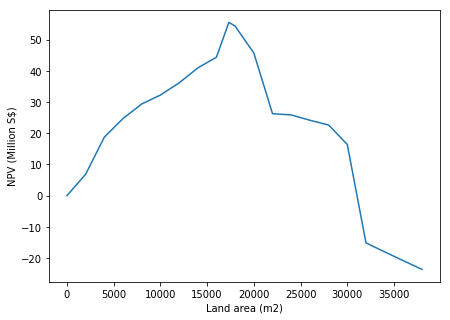

Optimized land area (sqm):             17,325.00
Max. NPV ($):         55,527,521.57


In [12]:
import matplotlib.pyplot as plt

NPV_dict = dict(collections.OrderedDict(sorted(NPV_dict.items())))

plt.plot(list(NPV_dict.keys()), [i/1000000 for i in list(NPV_dict.values())])
plt.xlabel('Land area (m2)')
plt.ylabel('NPV (Million S$)')
plt.show()

opt_land_area = max(NPV_dict.items(), key=operator.itemgetter(1))[0]
print('Optimized land area (sqm): ', '{:20,.2f}'.format(opt_land_area))
print('Max. NPV ($): ', '{:20,.2f}'.format(NPV_dict[opt_land_area]))

Optimum land area (sqm):  17325.0


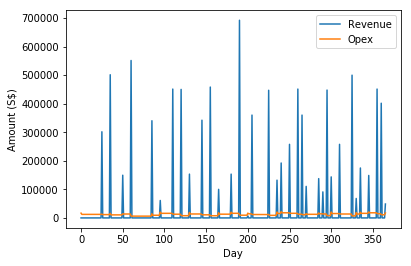

Total yearly revenue:          9,890,643.25
Total yearly opex:          4,601,340.05
Total yearly profit:          5,289,303.20


In [8]:
import operator

print('Optimum land area (sqm): ', opt_land_area)
res = planning(opt_land_area, [0,0,0], {0: [0,0,0]})
revenue = res[0]
cost = res[1]
quantity_to_produce = res[2]

day = [int(i) for i in list(revenue.keys())]
rev = revenue.values()
cos = cost.values()
pro = np.cumsum([r - c for r, c in zip(rev, cos)])

fig = plt.plot(day, rev, cos)
#fig = plt.plot(day, pro)
plt.xlabel('Day')
plt.ylabel('Amount (S$)')
plt.autoscale(enable=True, axis='both', tight=None)
plt.axis('auto')
plt.legend(['Revenue', 'Opex', 'Profit'])
plt.rcParams['figure.figsize'] = (7,5)
plt.show()

print('Total yearly revenue: ', '{:20,.2f}'.format(sum(rev)))
print('Total yearly opex: ', '{:20,.2f}'.format(sum(cos)))
print('Total yearly profit: ', '{:20,.2f}'.format(pro[-1]))

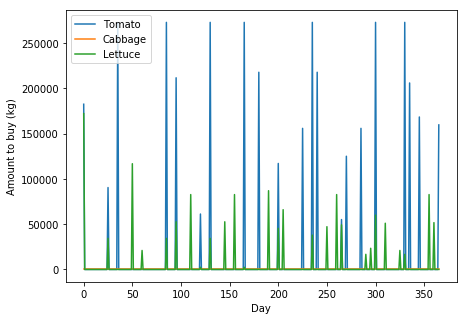

In [9]:
# plot crops to plant after each harvest cycle

# quantity_to_produce

t = [i[0] for i in quantity_to_produce.values()]
c = [i[1] for i in quantity_to_produce.values()]
l = [i[2] for i in quantity_to_produce.values()]

plt.plot(day, t)
plt.plot(day, c)
plt.plot(day, l)
plt.xlabel('Day')
plt.ylabel('Amount to buy (kg)')
#plt.autoscale(enable=True, axis='both', tight=None)
#plt.axis('auto')
plt.legend(['Tomato', 'Cabbage', 'Lettuce'])
plt.rcParams['figure.figsize'] = (7,5)
plt.show()

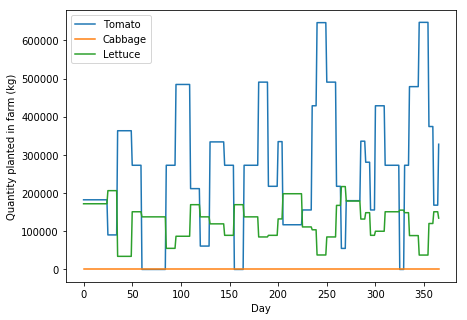

In [10]:
# stock

stock = list(res[3].values())

t = [i[0] for i in stock]
c = [i[1] for i in stock]
l = [i[2] for i in stock]

plt.plot(day, t)
plt.plot(day, c)
plt.plot(day, l)
plt.xlabel('Day')
plt.ylabel('Quantity planted in farm (kg)')
#plt.autoscale(enable=True, axis='both', tight=None)
#plt.axis('auto')
plt.legend(['Tomato', 'Cabbage', 'Lettuce'])
plt.rcParams['figure.figsize'] = (7,5)
plt.show()

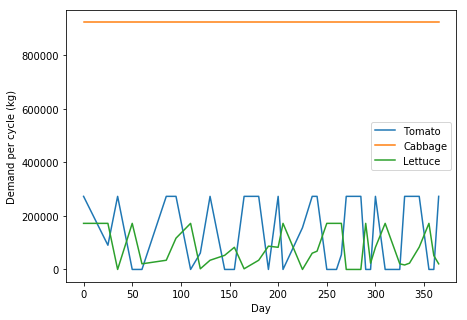

In [11]:
# demand

day = list(res[4].keys())
demand = list(res[4].values())

t = [i[0] for i in demand]
c = [i[1] for i in demand]
l = [i[2] for i in demand]

plt.plot(day, t)
plt.plot(day, c)
plt.plot(day, l)
plt.xlabel('Day')
plt.ylabel('Demand per cycle (kg)')
#plt.autoscale(enable=True, axis='both', tight=None)
#plt.axis('auto')
plt.legend(['Tomato', 'Cabbage', 'Lettuce'])
plt.rcParams['figure.figsize'] = (7,5)
plt.show()